# PCA of a image ? What will we get?

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider

Image Shape: (666, 1000, 3)


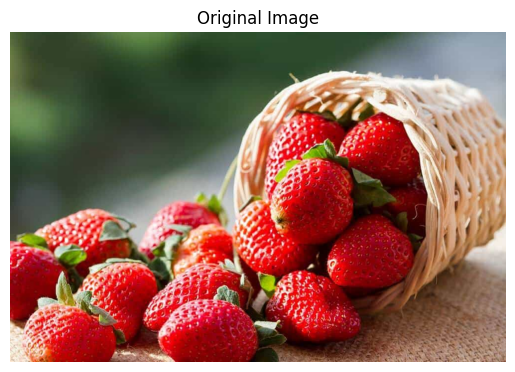

In [ ]:
#import image
#img = plt.imread('../../data/the-hand.jpg')
#img = plt.imread('../../data/monkey.jpg') 
img = plt.imread('../../data/strawberry_f_forever.jpg') 

print("Image Shape:", img.shape)

plt.imshow(img)
plt.title("Original Image")
plt.axis('off')
plt.show()


In [49]:
def compute_PCA(R,G,B):
    #Step 1: Build X
    # R,G and B are matrix, we have to build the X matrix where every column is an vector of every channel color
    R_vec = R.reshape(-1)
    G_vec = G.reshape(-1)
    B_vec = B.reshape(-1)

    # m = rows, n = columns    
    m =  R_vec.shape[0]; n=3
    X = np.column_stack([R_vec,G_vec,B_vec])

    #Step 2: center the data; build Z = X - [1 1 1 ... 1].T @ u
    # u is the vector of median of every column
    u = np.sum(X, axis=0) / m
    #more save use u = np.mean(X, axis=0)

    #ones_col_vec = np.array([np.ones(m)]).T
    #Z = X - ones_col_vec @ u
    # is not necesesary vectors of ones Z = X - u
    Z = X - u

    #step3: cov matrix
    M = (Z.T @ Z) / (m -1 )

    #step 4: Eigen vec and eigen val
    eigen_val, eigen_vec = np.linalg.eig(M)
    # V is the eigen_vec order high -> low, and in columns of V
    sorted_idx = np.argsort(eigen_val)[::-1] #get the index of sort in reverse order
    eigen_val = eigen_val[sorted_idx] 
    eigen_vec = eigen_vec[:, sorted_idx] # sort the columns

    V = eigen_vec
    
    #step 5. Get the basis
    #Remember Z = Y @ V.T --> with a change of base
    # V is ortogonal -> V.T = V^-1
    # so Y = Z V
    Y = Z @ V

    return Z, Y, V, u, eigen_val




In [54]:
#extract the R G B pixels matrix
img_float = img.astype(np.float32) / 255.0 # for imshow with RGB data ([0..1] for floats
R = img_float[:,:, 0]
G = img_float[:,:, 1]
B = img_float[:,:, 2]

In [ ]:
height, width, _ = img.shape

# PCA
Z, Y, V, u, eigen_val = compute_PCA(R, G, B)
# to reconstruct the image z=a⋅R+b⋅G+c⋅B
#for the case in black and white image is proyected the pixel from 3D -> 1D

@interact(k=IntSlider(min=1, max=3, step=1, value=2))
def show_pca_approx(k):
    """
    Visualiza la imagen reconstruida usando los primeros k componentes principales.
    """
    # Paso 1: first k columns of V
    V_k = V[:, :k]   # (3, k)
    
    # Paso 2: Project to reduced dimensions
    Y_k = Z @ V_k    # (m, k)

    # Paso 3: Reconstruction from Y_k
    Z_hat = Y_k @ V_k.T    # (m, 3)

    # Paso 4: Decenter
    X_hat = Z_hat + u      # (m, 3)

    # Paso 5: Reconstruct the image
    img_approx = X_hat.reshape((height, width, 3))
    img_approx = np.clip(img_approx, 0, 1)  

    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    axes[0].imshow(img_approx)
    axes[0].set_title(f"PCA Reconstruction with k={k}")
    axes[0].axis('off')

    axes[1].imshow(img)
    axes[1].set_title("Original Image")
    axes[1].axis('off')

    plt.tight_layout()
    plt.show()

interactive(children=(IntSlider(value=2, description='k', max=3, min=1), Output()), _dom_classes=('widget-inte…

# Save the image

In [45]:
import imageio
import numpy as np

def save_pca_jpeg(k, R, G, B, filename="pca_output.jpg"):
    """
    Saves a PCA-compressed image using the top-k principal components.

    Parameters:
    - k: number of principal components to use (1 to 3)
    - R, G, B: original RGB channel matrices (values between 0 and 1)
    - filename: output JPEG file name
    """
    # Step 1: Compute PCA
    Z, Y, V, u, _ = compute_PCA(R, G, B)

    # Step 2: Keep first k principal components
    V_k = V[:, :k]        # (3, k)
    Y_k = Z @ V_k         # (N, k)

    # Step 3: Reconstruct the centered data
    Z_hat = Y_k @ V_k.T   # (N, 3)
    X_hat = Z_hat + u     # (N, 3)

    # Step 4: Reshape to image format
    height, width = R.shape
    img_approx = X_hat.reshape((height, width, 3))
    img_uint8 = np.clip(img_approx * 255, 0, 255).astype(np.uint8)

    # Step 5: Save as JPEG
    imageio.imwrite(filename, img_uint8)
    print(f"PCA image with k={k} saved as '{filename}'")

In [ ]:
save_pca_jpeg(1, R, G, B, "pca_k1.jpg")
#save_pca_jpeg(2, R, G, B, "pca_k2.jpg")
#save_pca_jpeg(3, R, G, B, "pca_k3.jpg")

PCA image with k=2 saved as 'strayberry.jpg'


# Conclusion ?

We built the PCA algorithm and used it to "compress images" — not by changing their size, but by projecting their colors onto a lower-dimensional space.

Instead of working with full RGB color (3 dimensions), we told PCA:

"Hey, can you summarize the most important color directions?"

And it did exactly that. So maintaining the image itself but with less colors

With 3 components (k=2), we get back the original image.

With 2 components, we project all the pixel colors into a 2D color space — the image still looks colorful, but a bit "washed out".

With 1 component, all colors lie on a single line in RGB space. The result is something that looks grayscale, but it’s not a simple average — it’s the most meaningful direction of color variance in the image.

We saw that even though every pixel still has R, G, and B values, they're no longer independent — they’re just scaled versions of one principal direction.

This project showed how color itself can be compressed through projections, and how PCA finds those directions automatically.


### Key steps of PCA in image color compression

Given a centered color matrix $Z \in \mathbb{R}^{n \times 3}$ (where each row is a centered RGB pixel vector), PCA proceeds as:

- Compute the covariance matrix:
  $$
  C = \frac{1}{n - 1} Z^\top Z
  $$
- Compute eigenvalues and eigenvectors of $C$:
  $$
  C v_i = \lambda_i v_i
  $$
- Sort eigenvectors by descending eigenvalues to form $V = [v_1 \ v_2 \ v_3]$
- Project onto the top-$k$ components:
  $$
  Y = Z \cdot V_k
  $$

---

### Reconstruction formulas

Using the top-$k$ components, we can approximate the original centered data:

**Matrix form:**
$$
\hat{Z} = Y \cdot V_k^\top
$$

**Add back the mean to reconstruct original values:**
$$
\hat{X} = \hat{Z} + \mu
$$

**Vector form (for a single pixel):**
$$
\hat{x}_i = z_i \cdot V_k^\top + \mu
$$

Here:
- $z_i$ is the $i$-th row of $Y$
- $V_k$ contains the top-$k$ eigenvectors
- $\mu$ is the original mean RGB vector

---

### What should PCA return?

For this application, the essential outputs of PCA are:

- **$V$**: the matrix of principal components (eigenvectors)
- **$\lambda$**: the eigenvalues (explained variance)
- **$\mu$**: the mean vector of the original data
- **$Y$**: the projection of the data into the lower-dimensional space

---

By projecting RGB data into 2 or 1 dimensions and then reconstructing, we create images that have **less color information but preserve structure**. With only 1 component, all pixel colors lie along a single direction in RGB space — which is why the image appears grayscale-like, even though it's still technically in color.
